In [1]:
import numpy as np
import glob
import h5py
import os
import mne
from mne.channels import make_standard_montage
import matplotlib.pyplot as plt

pathDataRaw     = '/Users/obando_c/Documents/Neuro/EmergencyBraking/data/raw/'
index_subject = 12 # Take a subject 


rawFiles   = glob.glob(pathDataRaw+"*.mat")
subject_id    = rawFiles[index_subject][-8:]
nSubjects    = len (rawFiles)
nChannels    = 59

path_data_save_csv = os.path.normpath(os.path.join('/Users/obando_c/Documents/Neuro/EmergencyBraking/data/post_processed/' + subject_id[:-4] ))


# MNE parameters
fs = 200
tmin = -0.3  # Target segment interval intial point -> corresponds to 300ms before the event
tmax = 1.2  # Target segment interval final point -> corresponds to 1200ms after the event
filter_1 = 45.
nTimeStep    = int((abs(tmin) + tmax)*fs + 1)
baseline_correction = 0.1
ch_types = 'eeg'
event_id = {'braking': 0, 'collision': 1}  #
montage_std = make_standard_montage('biosemi64') # eeg montage

# Import data to MNE for one subject

In [2]:
epochs_reject = 0
with h5py.File(rawFiles  [index_subject], 'r') as f:
    mrk = f.get('mrk')
    time_mrk = np.array(mrk.get('time'))  # mrk.time is the timestamp for each event in milliseconds
    y = np.array(mrk.get('y')) 

    ###### Events
    car_brake = time_mrk.T * y[:, 1]  # contains the time in ms of events car_brake
    car_collision = time_mrk.T * y[:, 3]

    events = np.array(car_brake[car_brake > 0] / 5).astype(int)

    ### Collision Events
    # Find events with collision when comparing car_brake, car_collision, no need to convert with /5
    car_brake_y = car_brake[car_brake > 0]
    car_collision_y = car_collision[car_collision > 0]

    collison_label    = []
    for j in range(len(car_brake_y)):
        diff = car_collision_y - car_brake_y[j]
        if (len(diff[diff > 0]) == 0):
            collison_label.append(0)
        elif (min(diff[diff > 0]) > 25000):  # car_brake_y[i] is too far from any collision, so label = 0, 25000 is
            collison_label.append(0)
        else:
            collison_label.append(1)
    ##### Matrix of events anotations
    events_collison = np.empty([len(events), 3], dtype=int)
    events_collison[:, 0] = events
    events_collison[:, 1] = int(0)
    events_collison[:, 2] = np.array(collison_label).astype(int)

    cnt = f.get('cnt')
    x = np.array(cnt.get('x'))
    test = f['cnt/clab']
    name_elec = list()
    for j in range(len(test)):
        st = test[j][0]
        obj = f[st]
        str1 = ''.join(chr(i) for i in obj[:])
        name_elec.append(str1)
    channels_eeg = np.delete(np.arange(61), [0, 5])

    ###### EEG data in MNE
    ch_names = np.array(name_elec)[channels_eeg]
    eeg_data = x[channels_eeg, :]
    info = mne.create_info(ch_names=ch_names.tolist(), sfreq=fs, ch_types=ch_types)  # , ch_types = ch_types)
    info.set_montage(montage_std)
    raw = mne.io.RawArray(eeg_data, info)
    #eegbci.standardize(raw) 

    ###### Filter Data - seems as if the low pass was indeed already applied
    #raw = raw.copy()
    #raw.filter(None, filter_1, fir_design='firwin')

    #   Set up amplitude-peak rejection values for EEG channels
    reject = dict(eeg=1e3) # Set the correct value 1e3, where did I take this vlaue from?

    ##### Picks
    picks = mne.pick_types (raw.info, meg=False, eeg=True, eog=False,
                            exclude='bads')

    ##### Epochs
    epochs = mne.Epochs(raw, events_collison, event_id, tmin=tmin, tmax=tmax, proj=True,
                        picks=picks, baseline=(None, baseline_correction), preload=True,
                        reject=reject)

    ## Only PLOT ONCE
    #epochs['braking'].average().plot(time_unit='ms', titles="Normal Braking").savefig("plots/collision_vs_braking_epochs_allsubjects/epochs_braking"+ '%s_subject.png' % (i))
    #epochs['collision'].average().plot(time_unit='ms', titles="Collision").savefig("plots/collision_vs_braking_epochs_allsubjects/epochs_collision"+ '%s_subject.png' % (i))
    #plt.close()

    brr = [len(epochs.drop_log[i]) for i in range(len(epochs.drop_log))]
    epochs_reject += len(np.where(np.array(brr) !=0)[0])
    
    signalEvent = epochs['collision']._data
    signalNoEvent = epochs['braking']._data

Creating RawArray with float64 data, n_channels=59, n_times=1619936
    Range : 0 ... 1619935 =      0.000 ...  8099.675 secs
Ready.
Not setting metadata
Not setting metadata
227 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 227 events and 301 original time points ...
0 bad epochs dropped


In [3]:
nEvent       = len (signalEvent)
nNoEvent     = len (signalNoEvent)
nSample      = nEvent + nNoEvent

# For classification problems separate from the begining my training, validation and test sets
n_trainEvent= int(nEvent*0.8*0.8)
n_testEvent = int(nEvent*0.2)
n_valEvent  = nEvent - n_trainEvent - n_testEvent

n_trainNoEvent= int(nNoEvent*0.8*0.8)
n_testNoEvent = int(nNoEvent*0.2)
n_valNoEvent  = nNoEvent - n_trainNoEvent - n_testNoEvent

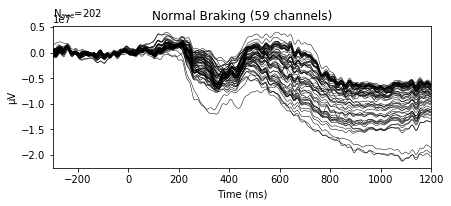

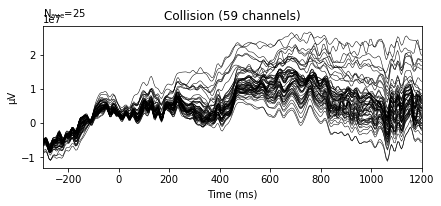

In [4]:
# We can treat the epochs object as we would any other
epochs['braking'].average().plot(time_unit='ms', titles="Normal Braking")
epochs['collision'].average().plot(time_unit='ms', titles="Collision")
plt.show()

## KL decomposition

### Prepare data in train, validation and test sets

In [5]:
muEvent_train      = np.mean (signalEvent[:n_trainEvent], axis=0)
signalsCEvent_train = signalEvent[:n_trainEvent] - muEvent_train

muEvent_val      = np.mean (signalEvent[n_trainEvent:n_trainEvent+n_valEvent], axis=0)
signalsCEvent_val = signalEvent[n_trainEvent:n_trainEvent+n_valEvent] - muEvent_val

muEvent_test      = np.mean (signalEvent[n_testEvent:], axis=0)
signalsCEvent_test = signalEvent[n_testEvent:] - muEvent_test

In [6]:
muNoEvent_train      = np.mean (signalNoEvent[:n_trainNoEvent], axis=0)
signalsCNoEvent_train = signalNoEvent[:n_trainNoEvent] - muNoEvent_train

muNoEvent_val      = np.mean (signalNoEvent[n_trainNoEvent:n_trainNoEvent+n_valNoEvent], axis=0)
signalsCNoEvent_val = signalNoEvent[n_trainNoEvent:n_trainNoEvent+n_valNoEvent] - muNoEvent_val

muNoEvent_test      = np.mean (signalNoEvent[n_testNoEvent:], axis=0)
signalsCNoEvent_test = signalNoEvent[n_testNoEvent:] - muNoEvent_test

### Saptio-temporal mesh

In [7]:
file_name = rawFiles  [index_subject] 
with h5py.File(file_name, 'r') as f:
    mnt = f.get('mnt')
    pos3d_allChannels = np.array(mnt.get('pos_3d')) 

pos3d_eegChannels = pos3d_allChannels[np.delete(np.arange(61), [0, 5])]

spatiotemp_mesh = []
for p in pos3d_eegChannels[:nChannels]: 
    xi, yi, zi = tuple(p)
    for ti in range(nTimeStep):
        spatiotemp_mesh.append([xi, yi, zi, ti])

* KL decomposition over Events

In [8]:
import openturns as ot
dim_ch_in  = 1 
dim_ch_out = 1 
process_sampleEvent_train = ot.ProcessSample(ot.Mesh(spatiotemp_mesh), n_trainEvent, dim_ch_in) 
process_sampleEvent_val   = ot.ProcessSample(ot.Mesh(spatiotemp_mesh), n_valEvent, dim_ch_in) 
process_sampleEvent_test  = ot.ProcessSample(ot.Mesh(spatiotemp_mesh), n_testEvent, dim_ch_in) 

field          = ot.Field(ot.Mesh(spatiotemp_mesh), dim_ch_out) 
for k in range(nEvent):
    if k < n_trainEvent:
        field.setValues(signalsCEvent_train[k].reshape(-1,1))
        process_sampleEvent_train[k] = field
        
    elif k < n_trainEvent + n_valEvent:
        field.setValues(signalsCEvent_val[k - n_trainEvent].reshape(-1,1))
        process_sampleEvent_val[k - n_trainEvent] = field
        
    else:
        field.setValues(signalsCEvent_test[k - n_trainEvent - n_valEvent ].reshape(-1,1))
        process_sampleEvent_test[k - n_trainEvent - n_valEvent ] = field

s    = 0.0 
w_v  = np.ones(nChannels*nTimeStep) 
algo = ot.KarhunenLoeveSVDAlgorithm(process_sampleEvent_train,w_v, s) 
algo.run()

fPCAEvent_train     = algo.getResult()

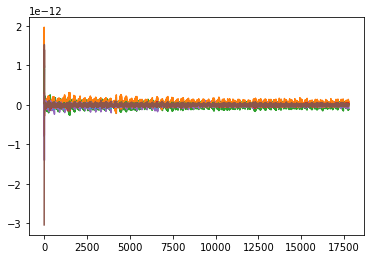

In [9]:
## TODO ONCE
XiEvent       = fPCAEvent_train.project(process_sampleEvent_train) # Project a function or a field on the eigenmodes basis.
XiEventLambda = XiEvent * ot.Point([np.sqrt(x) for x in fPCAEvent_train.getEigenValues()])

T     = np.array([t for t in spatiotemp_mesh]) # 
V_app = ot.DualLinearCombinationFunction(fPCAEvent_train.getModes(), np.array(XiEventLambda).T) # TO reconstruct the signal

for k in range(process_sampleEvent_train.getSize()): 
    res = process_sampleEvent_train[k].getValues() - V_app .getMarginal(k)(T)
    plt.plot (res)

In [10]:
vpEvent       = fPCAEvent_train.getEigenValues()
PhiEvent      = fPCAEvent_train.getModes()
XiEvent       = np.array(fPCAEvent_train.project(process_sampleEvent_train))
XiLambdaEvent = XiEvent * ot.Point([np.sqrt(x) for x in vpEvent])
TEvent        = np.array([t for t in spatiotemp_mesh])
V_appEvent    = ot.DualLinearCombinationFunction(fPCAEvent_train.getModes(), np.array(XiLambdaEvent).T) 

np.array(XiEvent).tofile(path_data_save_csv + '_XiEvent', sep = ',')

* KL decomposition over NoEvents

In [11]:
import openturns as ot
dim_ch_in  = 1 
dim_ch_out = 1 
process_sampleNoEvent_train = ot.ProcessSample(ot.Mesh(spatiotemp_mesh), n_trainNoEvent, dim_ch_in) 
process_sampleNoEvent_val   = ot.ProcessSample(ot.Mesh(spatiotemp_mesh), n_valNoEvent, dim_ch_in) 
process_sampleNoEvent_test  = ot.ProcessSample(ot.Mesh(spatiotemp_mesh), n_testNoEvent, dim_ch_in) 

field          = ot.Field(ot.Mesh(spatiotemp_mesh), dim_ch_out) 
for k in range(nNoEvent):
    if k < n_trainNoEvent:
        field.setValues(signalsCNoEvent_train[k].reshape(-1,1))
        process_sampleNoEvent_train[k] = field
    elif k < n_trainNoEvent + n_valNoEvent:
        field.setValues(signalsCNoEvent_val[k - n_trainNoEvent].reshape(-1,1))
        process_sampleNoEvent_val[k - n_trainNoEvent] = field
    else:
        field.setValues(signalsCNoEvent_test[k - n_trainNoEvent - n_valNoEvent].reshape(-1,1))
        process_sampleNoEvent_test[k - n_trainNoEvent - n_valNoEvent ] = field

s    = 0.0 
w_v  = np.ones(nChannels*nTimeStep) 
algo = ot.KarhunenLoeveSVDAlgorithm(process_sampleNoEvent_train,w_v, s) 
algo.run()

fPCANoEvent_train     = algo.getResult()

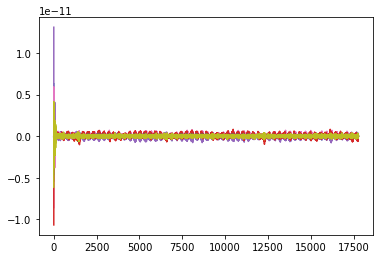

In [12]:
## TODO ONCE
XiNoEvent       = fPCANoEvent_train.project(process_sampleNoEvent_train) # Project a function or a field on the eigenmodes basis.
XiNoEventLambda = XiNoEvent * ot.Point([np.sqrt(x) for x in fPCANoEvent_train.getEigenValues()])

T     = np.array([t for t in spatiotemp_mesh]) # 
V_app = ot.DualLinearCombinationFunction(fPCANoEvent_train.getModes(), np.array(XiNoEventLambda).T) # TO reconstruct the signal

for k in range(process_sampleNoEvent_train.getSize()): 
    res = process_sampleNoEvent_train[k].getValues() - V_app .getMarginal(k)(T)
    plt.plot (res)

In [13]:
vpNoEvent       = fPCANoEvent_train.getEigenValues()
PhiNoEvent      = fPCANoEvent_train.getModes()
XiNoEvent       = np.array(fPCANoEvent_train.project(process_sampleNoEvent_train))
XiLambdaNoEvent = XiNoEvent * ot.Point([np.sqrt(x) for x in vpNoEvent])
TNoEvent        = np.array([t for t in spatiotemp_mesh])
V_appNoEvent    = ot.DualLinearCombinationFunction(fPCANoEvent_train.getModes(), np.array(XiLambdaNoEvent).T) 

np.array(XiNoEvent).tofile(path_data_save_csv + '_XiNoEvent', sep = ',')

In [ ]:
# Generate nGenerate Event segments
path_data_save_csv = os.path.normpath(os.path.join('/Users/obando_c/Documents/Neuro/EmergencyBraking/data/post_processed/sampled_collision_subject_' + str(index_subject) + ' _KL_trianvaltest_csv'))
if not os.path.exists(path_data_save_csv):
    os.makedirs(path_data_save_csv)
    
nGenerate = 100 #10000
nbModesEvent = process_sampleEvent_train.getSize() - 1
T     = np.array([t for t in spatiotemp_mesh]) # 
Eventmodes = fPCAEvent_train.getModes()
EventsubModes    = [Eventmodes[i] for i in range (nbModesEvent)]

dist_multi_Event = ot.KernelSmoothing().build(XiEvent[:,:nbModesEvent])
XiEventSample  = dist_multi_Event.getSample(nGenerate)
XiLambdaSample = np.array(XiEventSample) * ot.Point([np.sqrt(x) for x in fPCAEvent_train.getEigenValues()[:nbModesEvent]])
V_app       = ot.DualLinearCombinationFunction(EventsubModes, np.array(XiLambdaSample).T)

index_var = 0 # default 0
for k in range(nGenerate):
    Event_sample = V_app .getMarginal(k)(T)
    A = np.array(Event_sample).reshape(59,301) #sample event
    
    #path_out = os.path.join(path_data_save, '%s_segment_train_%d_event.npy' % (index_var + k, 1))
    #np.save(path_out, A)
    
    path_out_csv = os.path.join(path_data_save_csv, '%s_segment_train_%d_event.csv' % (index_var + k, 1))
    A.tofile(path_out_csv, sep = ',')
   

In [ ]:
# Generate nGenerate NoEvent segments
path_data_save_csv = os.path.normpath(os.path.join('/Users/obando_c/Documents/Neuro/EmergencyBraking/data/post_processed/sampled_collision_subject_' + str(index_subject) + ' _KL_trianvaltest_csv'))
if not os.path.exists(path_data_save_csv):
    os.makedirs(path_data_save_csv)
    
nGenerate = 100 # 
nbModesNoEvent = process_sampleNoEvent_train.getSize() - 1
T     = np.array([t for t in spatiotemp_mesh]) # 
NoEventmodes = fPCANoEvent_train.getModes()
NoEventsubModes    = [NoEventmodes[i] for i in range (nbModesNoEvent)]

dist_multi_NoEvent = ot.KernelSmoothing().build(XiNoEvent[:,:nbModesNoEvent])
XiNoEventSample  = dist_multi_NoEvent.getSample(nGenerate)
XiLambdaSample = np.array(XiNoEventSample) * ot.Point([np.sqrt(x) for x in fPCANoEvent_train.getEigenValues()[:nbModesNoEvent]])
V_app       = ot.DualLinearCombinationFunction(NoEventsubModes, np.array(XiLambdaSample).T)

index_var = 10000 # default 0
for k in range(nGenerate):
    NoEvent_sample = V_app .getMarginal(k)(T)
    #path_out = os.path.join(path_data_save, '%s_segment_train_%d_noevent.npy' % (index_var + k, 0))
    path_out_csv = os.path.join(path_data_save_csv, '%s_segment_train_%d_noevent.csv' % (index_var + k, 0))
    A = np.array(NoEvent_sample).reshape(59,301) #sample noevent
    A.tofile(path_out_csv, sep = ',')
    

### Save data as it is to fit NN on the raw examples

In [ ]:
nEvent = epochs['collision']._data.shape[0]
nNoEvent = epochs['braking']._data.shape[0]

In [ ]:
nEvent + nNoEvent

In [ ]:
subj_indx = 12
path_data_save = os.path.normpath(os.path.join('/Users/obando_c/Documents/Neuro/EmergencyBraking/data/post_processed/persubject_epochs_collision/subject_' + str(subj_indx) +'_collision_trianvaltest'))

if not os.path.exists(path_data_save):
    os.makedirs(path_data_save)
    
for k in range(nEvent):
    path_out = os.path.join(path_data_save, '%s_segment_%d_event.npy' % (k, 0))
    A = epochs['collision']._data[k]
    np.save(path_out, A)
    
for k in range(nNoEvent):
    path_out = os.path.join(path_data_save, '%s_segment_%d_noevent.npy' % (k, 0))
    A = epochs['braking']._data[k]
    np.save(path_out, A)
    

In [ ]:
subj_indx = 12
path_data_save = os.path.normpath(os.path.join('/Users/obando_c/Documents/Neuro/EmergencyBraking/data/post_processed/subject_'+ str(subj_indx)+'_events_collision/'))

if not os.path.exists(path_data_save):
    os.makedirs(path_data_save)
    
for k in range(nEvent):
    path_out = os.path.join(path_data_save, '%s_segment_%d_event.npy' % (rawFiles [i][-8:], k))
    A = epochs['collision']._data[k]
    np.save(path_out, A)
    
for k in range(nNoEvent):
    path_out = os.path.join(path_data_save, '%s_segment_%d_noevent.npy' % (rawFiles [i][-8:],k))
    A = epochs['braking']._data[k]
    np.save(path_out, A)